# Import

## Import libraries


In [9]:
import pandas as pd
import numpy as np      
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.cm as cm
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
# import csv from clean transcripts/NVIDIA_full_output.csv
import pandas as pd

df = pd.read_csv("NVIDIA_full.csv", index_col=False, header=0)
df.head()

,quarter,speaker,title,content,sentiment,confidence,sentiment_category,LLM_sentiment,LLM_pct_strong_positive,LLM_pct_slightly_positive,LLM_pct_neutral,LLM_pct_slightly_negative,LLM_pct_strong_negative,Manual Annotation
0,Q1_2025,Simona Jankowski,"Vice President, Investor Relations",They just revealed what they believe are the 1...,neutral,0.949520,Neutral,Neutral,0.10,0.10,0.7,0.05,0.05,Neutral
1,Q1_2025,Colette Kress,"Executive Vice President, Chief Financial Officer","Thanks, Simona. Q1 was another record quarter....",positive,0.952649,Strong Positive,Slightly Positive,0.20,0.50,0.2,0.05,0.05,Strong Positive
2,Q1_2025,Jensen Huang,President and Chief Operating Officer,"Thanks, Colette. The industry is going through...",neutral,0.758597,Neutral,Slightly Positive,0.30,0.40,0.2,0.05,0.05,Strong Positive
3,Q1_2025,Simona Jankowski,"Vice President, Investor Relations","Thank you, Jensen. We will now open the call f...",neutral,0.931907,Neutral,Neutral,0.05,0.05,0.8,0.05,0.05,Neutral
4,Q1_2025,Stacy Rasgon,AllianceBernstein -- Analyst,"Hi, guys. Thanks for taking my questions. My f...",neutral,0.893501,Neutral,Neutral,0.05,0.10,0.7,0.10,0.05,Neutral


# 1.0 FinBERT vs LLM vs Manual Annotation

In [11]:
# --- Setup ---
# pip install scikit-learn seaborn  # (run this in a cell if you don't already have them)
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns  # optional, just for a nicely formatted table

# === CONFIG: set your actual column names here ===
Y_TRUE_COL = "Manual Annotation"     # e.g. 'ground_truth' or 'human_label'
Y_PRED_COL = "sentiment_category"     # e.g. 'model_label'
QUARTER_COL = "quarter"       # e.g. 'fiscal_quarter'
# ================================================

# If your classes are exactly these strings, keep them as is.
# This order will be used for the confusion matrix axes and reports.
CLASS_ORDER = [
    "Strong Positive",
    "Slightly Positive",
    "Neutral",
    "Slightly Negative",
    "Strong Negative"
]

# ----- Helper: safe classification metrics for a subset -----
def compute_basic_metrics(y_true, y_pred, labels):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

# ================== MAIN ANALYSIS ==================

# 1) Keep only rows where we have both labels and a quarter
work = df[[Y_TRUE_COL, Y_PRED_COL, QUARTER_COL]].dropna().copy()

# 2) Enforce consistent ordered categories (helps with clean confusion matrices)
for c in [Y_TRUE_COL, Y_PRED_COL]:
    work[c] = pd.Categorical(work[c], categories=CLASS_ORDER, ordered=True)

# 3) Row-level eval frame you can reuse for plotting/stats later
work["is_correct"] = (work[Y_TRUE_COL] == work[Y_PRED_COL])


# 4) Overall metrics
overall_metrics = compute_basic_metrics(work[Y_TRUE_COL], work[Y_PRED_COL], CLASS_ORDER)
overall_report = classification_report(
    work[Y_TRUE_COL],
    work[Y_PRED_COL],
    labels=CLASS_ORDER,
    target_names=CLASS_ORDER,
    output_dict=True,
    zero_division=0
)
overall_report_df = pd.DataFrame(overall_report).T  # nice table

print("=== Overall metrics ===")
for k, v in overall_metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Per-class precision/recall/F1 ===")
display(overall_report_df)

# 5) Confusion matrices (counts and normalized)
cm_counts = confusion_matrix(
    work[Y_TRUE_COL], work[Y_PRED_COL],
    labels=CLASS_ORDER
)
cm_normalized = confusion_matrix(
    work[Y_TRUE_COL], work[Y_PRED_COL],
    labels=CLASS_ORDER,
    normalize="true"  # each row sums to 1
)

=== Overall metrics ===
accuracy: 0.5771
f1_macro: 0.3103
f1_weighted: 0.4851
precision_macro: 0.5551
recall_macro: 0.2982

=== Per-class precision/recall/F1 ===


,precision,recall,f1-score,support
Strong Positive,0.700000,0.132075,0.222222,53.000000
Slightly Positive,0.500000,0.128205,0.204082,39.000000
Neutral,0.575419,0.980952,0.725352,105.000000
Slightly Negative,1.000000,0.250000,0.400000,4.000000
Strong Negative,0.000000,0.000000,0.000000,0.000000
accuracy,0.577114,0.577114,0.577114,0.577114
macro avg,0.555084,0.298247,0.310331,201.000000
weighted avg,0.602085,0.577114,0.485069,201.000000


In [12]:
import numpy as np
import pandas as pd

# --- Setup
ALLOWED_STR = {str(x).strip() for x in CLASS_ORDER}

def typename(x):
    return type(x).__name__ if pd.notna(x) else "NaN"

def is_number(x):
    return isinstance(x, (int, float, np.integer, np.floating)) and not pd.isna(x)

def majority_type(s: pd.Series):
    t = s.map(typename)
    vc = t[t != "NaN"].value_counts()
    return vc.idxmax() if not vc.empty else None

yt = work[Y_TRUE_COL]
yp = work[Y_PRED_COL]

maj_true = majority_type(yt)
maj_pred = majority_type(yp)

diag = pd.DataFrame({
    "y_true": yt,
    "y_pred": yp,
})

# Canonical string forms
diag["y_true_str"] = yt.astype(str).str.strip()
diag["y_pred_str"] = yp.astype(str).str.strip()

# Type info
diag["y_true_type"] = yt.map(typename)
diag["y_pred_type"] = yp.map(typename)
diag["y_true_is_num"] = yt.map(is_number)
diag["y_pred_is_num"] = yp.map(is_number)

# Membership vs your class order (after stripping)
diag["y_true_in_allowed"] = diag["y_true_str"].isin(ALLOWED_STR)
diag["y_pred_in_allowed"] = diag["y_pred_str"].isin(ALLOWED_STR)

# Mark type outliers relative to the majority type in each column
diag["y_true_type_outlier"] = diag["y_true_type"].ne(maj_true) & diag["y_true_type"].ne("NaN")
diag["y_pred_type_outlier"] = diag["y_pred_type"].ne(maj_pred) & diag["y_pred_type"].ne("NaN")

# Overall problem flag
diag["problem"] = (
    ~diag["y_true_in_allowed"] |
    ~diag["y_pred_in_allowed"] |
    diag["y_true_type_outlier"] |
    diag["y_pred_type_outlier"]
)

# --- Summary
print("y_true types:\n", diag["y_true_type"].value_counts(dropna=False), "\n")
print("y_pred types:\n", diag["y_pred_type"].value_counts(dropna=False), "\n")

invalid_true = sorted(diag.loc[~diag["y_true_in_allowed"], "y_true_str"].unique().tolist())
invalid_pred = sorted(diag.loc[~diag["y_pred_in_allowed"], "y_pred_str"].unique().tolist())
print("Values in y_true NOT in CLASS_ORDER:", invalid_true)
print("Values in y_pred NOT in CLASS_ORDER:", invalid_pred, "\n")

# --- Rows to inspect
bad_rows = diag.index[diag["problem"]].tolist()
print(f"Found {len(bad_rows)} problematic row(s):", bad_rows[:20], "..." if len(bad_rows) > 20 else "")

# Show a compact view of the first few problematic rows
cols_to_show = [
    "y_true","y_pred","y_true_type","y_pred_type",
    "y_true_in_allowed","y_pred_in_allowed",
    "y_true_type_outlier","y_pred_type_outlier"
]
display(diag.loc[bad_rows, cols_to_show].head(20))


y_true types:
 y_true_type
str    201
Name: count, dtype: int64 

y_pred types:
 y_pred_type
str    201
Name: count, dtype: int64 

Values in y_true NOT in CLASS_ORDER: []
Values in y_pred NOT in CLASS_ORDER: [] 

Found 0 problematic row(s): [] 


,y_true,y_pred,y_true_type,y_pred_type,y_true_in_allowed,y_pred_in_allowed,y_true_type_outlier,y_pred_type_outlier



=== Overall metrics for FinBERT ===
accuracy: 0.5771
f1_macro: 0.3103
f1_weighted: 0.4851
precision_macro: 0.5551
recall_macro: 0.2982

=== Per-class precision/recall/F1 for FinBERT ===


,precision,recall,f1-score,support
Strong Positive,0.700000,0.132075,0.222222,53.000000
Slightly Positive,0.500000,0.128205,0.204082,39.000000
Neutral,0.575419,0.980952,0.725352,105.000000
Slightly Negative,1.000000,0.250000,0.400000,4.000000
Strong Negative,0.000000,0.000000,0.000000,0.000000
accuracy,0.577114,0.577114,0.577114,0.577114
macro avg,0.555084,0.298247,0.310331,201.000000
weighted avg,0.602085,0.577114,0.485069,201.000000


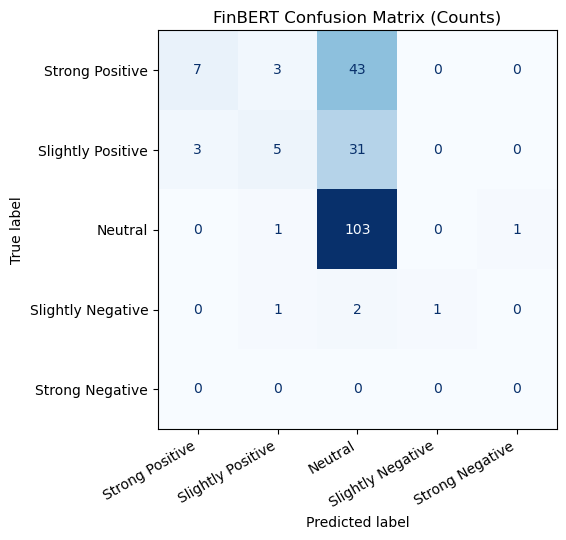

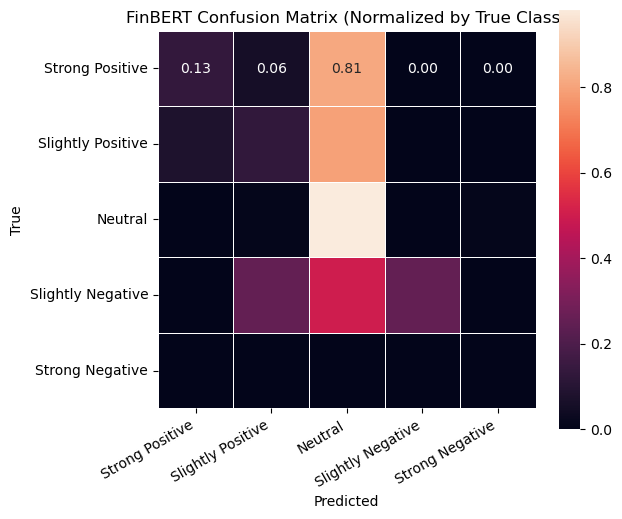


=== Per-quarter summary for FinBERT ===


,quarter,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,n,accuracy_pct,correct_pct
0,Q1_2024,0.769231,0.607143,0.727198,0.913043,0.550000,26.0,76.923077,76.923077
1,Q1_2025,0.633333,0.476633,0.560709,0.864198,0.472222,30.0,63.333333,63.333333
2,Q2_2024,0.560000,0.335979,0.432698,0.355072,0.400000,25.0,56.000000,56.000000
3,Q2_2025,0.545455,0.312500,0.423295,0.507937,0.380952,22.0,54.545455,54.545455
4,Q3_2024,0.476190,0.291667,0.357143,0.375000,0.333333,21.0,47.619048,47.619048
5,Q3_2025,0.555556,0.229487,0.465527,0.395833,0.261111,27.0,55.555556,55.555556
6,Q4_2023,0.423077,0.250962,0.334320,0.300000,0.310227,26.0,42.307692,42.307692
7,Q4_2025,0.625000,0.363363,0.510886,0.536232,0.400000,24.0,62.500000,62.500000



=== Overall metrics for LLM ===
accuracy: 0.6716
f1_macro: 0.6514
f1_weighted: 0.6480
precision_macro: 0.7547
recall_macro: 0.6139

=== Per-class precision/recall/F1 for LLM ===


,precision,recall,f1-score,support
Strong Positive,0.604167,0.547170,0.574257,53.0
Slightly Positive,0.733333,0.282051,0.407407,39.0
Neutral,0.681481,0.876190,0.766667,105.0
Slightly Negative,1.000000,0.750000,0.857143,4.0
Strong Negative,0.000000,0.000000,0.000000,0.0
micro avg,0.671642,0.671642,0.671642,201.0
macro avg,0.603796,0.491082,0.521095,201.0
weighted avg,0.677494,0.671642,0.648025,201.0


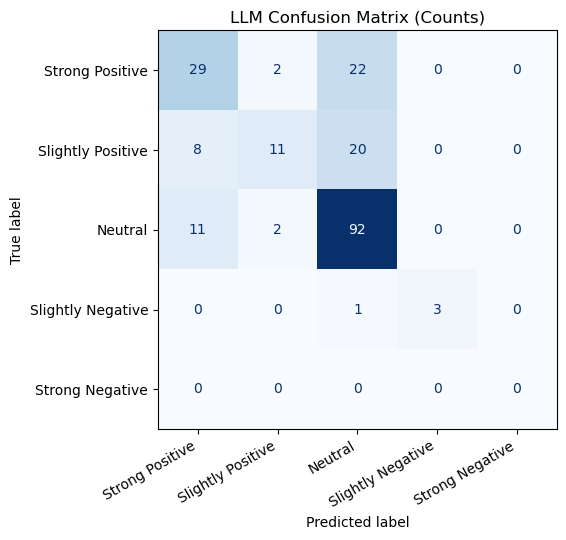

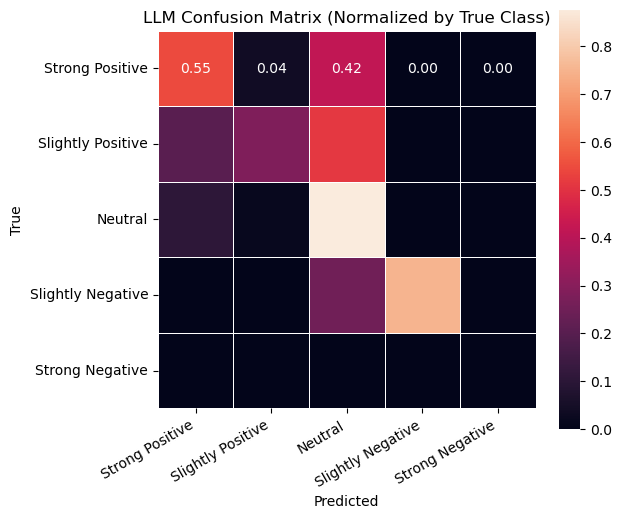


=== Per-quarter summary for LLM ===


,quarter,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro,n,accuracy_pct,correct_pct
0,Q1_2024,0.730769,0.719048,0.755495,0.733333,0.815686,26.0,73.076923,73.076923
1,Q1_2025,0.600000,0.409091,0.487879,0.523810,0.444444,30.0,60.000000,60.000000
2,Q2_2024,0.760000,0.740613,0.780810,0.818182,0.780220,25.0,76.000000,76.000000
3,Q2_2025,0.500000,0.289128,0.393288,0.333333,0.350649,22.0,50.000000,50.000000
4,Q3_2024,0.857143,0.810294,0.846218,0.916667,0.805556,21.0,85.714286,85.714286
5,Q3_2025,0.555556,0.293939,0.449495,0.353333,0.348148,27.0,55.555556,55.555556
6,Q4_2023,0.730769,0.515873,0.720391,0.504545,0.531818,26.0,73.076923,73.076923
7,Q4_2025,0.666667,0.449735,0.572751,0.545455,0.466667,24.0,66.666667,66.666667


In [13]:
# --- Setup ---
import pandas as pd
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- Function to evaluate one model ---
def evaluate_sentiment_model(df, y_true_col, y_pred_col, model_name, class_order, quarter_col):
    # Filter and clean
    work = df[[y_true_col, y_pred_col, quarter_col]].dropna().copy()

    # Set category order for consistency
    for c in [y_true_col, y_pred_col]:
        work[c] = pd.Categorical(work[c], categories=class_order, ordered=True)

    work["is_correct"] = (work[y_true_col] == work[y_pred_col])

    # --- Metrics function ---
    def compute_basic_metrics(y_true, y_pred, labels):
        return {
            "accuracy": accuracy_score(y_true, y_pred),
            "f1_macro": f1_score(y_true, y_pred, average="macro"),
            "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
            "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
            "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        }

    # --- Overall metrics ---
    overall_metrics = compute_basic_metrics(work[y_true_col], work[y_pred_col], class_order)
    overall_report = classification_report(
        work[y_true_col],
        work[y_pred_col],
        labels=class_order,
        target_names=class_order,
        output_dict=True,
        zero_division=0
    )
    overall_report_df = pd.DataFrame(overall_report).T

    print(f"\n=== Overall metrics for {model_name} ===")
    for k, v in overall_metrics.items():
        print(f"{k}: {v:.4f}")

    print(f"\n=== Per-class precision/recall/F1 for {model_name} ===")
    display(overall_report_df)

    # --- Confusion Matrices ---
    cm_counts = confusion_matrix(work[y_true_col], work[y_pred_col], labels=class_order)
    cm_normalized = confusion_matrix(work[y_true_col], work[y_pred_col], labels=class_order, normalize="true")

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_counts, display_labels=class_order)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} Confusion Matrix (Counts)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    sns.heatmap(pd.DataFrame(cm_normalized, index=class_order, columns=class_order),
                annot=True, fmt=".2f", linewidths=.5, square=True, cbar=True)
    ax.set_title(f"{model_name} Confusion Matrix (Normalized by True Class)")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.xticks(rotation=30, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- Per-quarter metrics ---
    def quarter_metrics(g):
        m = compute_basic_metrics(g[y_true_col], g[y_pred_col], class_order)
        m["n"] = len(g)
        m["accuracy_pct"] = 100 * m["accuracy"]
        m["correct_pct"] = 100 * g["is_correct"].mean()
        return pd.Series(m)

    quarter_summary = (
        work
        .groupby(quarter_col, dropna=False)
        .apply(quarter_metrics)
        .reset_index()
        .sort_values(quarter_col)
    )

    print(f"\n=== Per-quarter summary for {model_name} ===")
    display(quarter_summary)

# --- Configuration (common variables) ---
CLASS_ORDER = ["Strong Positive", "Slightly Positive", "Neutral", "Slightly Negative", "Strong Negative"]
QUARTER_COL = "quarter"
Y_TRUE_COL = "Manual Annotation"

# --- Run the comparison ---
evaluate_sentiment_model(df, Y_TRUE_COL, "sentiment_category", "FinBERT", CLASS_ORDER, QUARTER_COL)
evaluate_sentiment_model(df, Y_TRUE_COL, "LLM_sentiment", "LLM", CLASS_ORDER, QUARTER_COL)


# 2.0 Comparison of Sentiment Analysis against stock price movements

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go

# PARAMETERS
TICKER = "NVDA"

# Download earnings calendar
stock = yf.Ticker(TICKER)
earnings = stock.get_earnings_dates(limit=20)
earnings.index = pd.to_datetime(earnings.index).tz_localize(None)
earnings["Earnings Date"] = earnings.index.date
earnings_dates = [d for d in earnings["Earnings Date"].tolist() if d <= datetime.today().date()]

# Sentiment classifier
def categorize_sentiment(change):
    if change > 5:
        return "Strong Positive"
    elif change > 1:
        return "Slightly Positive"
    elif change >= -1:
        return "Neutral"
    elif change >= -5:
        return "Slightly Negative"
    else:
        return "Strong Negative"

# Collect results around earnings dates
results = []

for ed in earnings_dates:
    ed = pd.to_datetime(ed)
    start_date = ed - pd.Timedelta(days=5)
    end_date = ed + pd.Timedelta(days=5)
    
    data = yf.Ticker(TICKER).history(start=start_date, end=end_date)[['Close']].copy()
    data.index = data.index.tz_localize(None)
    trading_days = data.index

    try:
        t_minus_2 = trading_days[trading_days < ed][-2]
        t_plus_2 = trading_days[trading_days > ed][1]
    except IndexError:
        continue

    price_t_minus_2 = data.loc[t_minus_2, 'Close']
    price_t_plus_2 = data.loc[t_plus_2, 'Close']
    pct_change = ((price_t_plus_2 - price_t_minus_2) / price_t_minus_2) * 100
    sentiment = categorize_sentiment(pct_change)
    
    eps_row = earnings.loc[earnings["Earnings Date"] == ed.date()].iloc[0]

    results.append({
        "Earnings Date": ed.date(),
        "T-2 Date": t_minus_2.date(),
        "T+2 Date": t_plus_2.date(),
        "T-2 Price": round(price_t_minus_2, 2),
        "T+2 Price": round(price_t_plus_2, 2),
        "% Change": round(pct_change, 2),
        "Sentiment": sentiment,
        "EPS Estimate": eps_row["EPS Estimate"],
        "Reported EPS": eps_row["Reported EPS"],
        "Surprise(%)": eps_row["Surprise(%)"]
    })

df_results = pd.DataFrame(results)

# Download full price history
earliest_date = pd.to_datetime(min(df_results["Earnings Date"])) - pd.Timedelta(days=30)
df_full = yf.Ticker(TICKER).history(start=earliest_date)[['Close']].copy()
df_full.index = df_full.index.tz_localize(None)
df_full['Date'] = df_full.index

# Sentiment color mapping
sentiment_colors = {
    "Strong Positive": "green",
    "Slightly Positive": "lime",
    "Neutral": "gray",
    "Slightly Negative": "orange",
    "Strong Negative": "red"
}

# Plotly figure
fig = go.Figure()

# Add stock price line
fig.add_trace(go.Scatter(
    x=df_full['Date'], y=df_full['Close'],
    mode='lines', name=f'{TICKER} Price',
    line=dict(color='black')
))

# Add sentiment scatter markers
for _, row in df_results.iterrows():
    earnings_date = pd.to_datetime(row["Earnings Date"])
    price = df_full.loc[df_full['Date'] == earnings_date, 'Close']
    if price.empty:
        closest_idx = (df_full['Date'] - earnings_date).abs().idxmin()
        price = df_full.loc[closest_idx, 'Close']
        earnings_date = df_full.loc[closest_idx, 'Date']
    else:
        price = price.values[0]

    fig.add_trace(go.Scatter(
        x=[earnings_date], y=[price],
        mode='markers+text',
        marker=dict(
            color=sentiment_colors[row["Sentiment"]],
            size=12,
            line=dict(color='black', width=1)
        ),
        name=row["Sentiment"],
        hovertemplate=(
            f"<b>{earnings_date.date()}</b><br>"
            f"Surprise: {row['Surprise(%)']}%<br>"
            f"Change: {row['% Change']}%<br>"
            f"Reported EPS: {row['Reported EPS']}<br>"
            f"Estimate EPS: {row['EPS Estimate']}"
        ),
        showlegend=False
    ))

# Customize layout
fig.update_layout(
    title=f"{TICKER} Earnings Sentiment — EPS Surprise & Stock Reaction",
    xaxis_title="Date",
    yaxis_title="Close Price (USD)",
    template="plotly_white",
    legend_title="Sentiment",
    hovermode="closest"
)

# Manual sentiment legend
for sentiment, color in sentiment_colors.items():
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=10, color=color),
        legendgroup=sentiment,
        showlegend=True,
        name=sentiment
    ))

fig.show()


c:\Users\sadee\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [15]:
# Convert date to pandas datetime
df_results["Earnings Date"] = pd.to_datetime(df_results["Earnings Date"])

# Shift earnings date back by one quarter before formatting
df_results["quarter"] = (
    pd.to_datetime(df_results["Earnings Date"])
    .dt.to_period("Q")         # e.g. 2024Q3
    - 1                        # shift back one quarter → 2024Q2
).astype(str).str.replace(r"(\d{4})Q([1-4])", r"Q\2_\1", regex=True)




In [16]:
# Step 1: Define mapping
sentiment_to_score = {
    "Strong Negative": -2,
    "Slightly Negative": -1,
    "Neutral": 0,
    "Slightly Positive": 1,
    "Strong Positive": 2
}

# Step 2: Apply mapping to new numeric score columns
df["Manual Annotation_score"] = df["Manual Annotation"].map(sentiment_to_score)
df["sentiment_category_score"] = df["sentiment_category"].map(sentiment_to_score)
df["LLM_sentiment_score"] = df["LLM_sentiment"].map(sentiment_to_score)



In [17]:
# Step 3: Average sentiment scores by quarter
avg_sentiments = (
    df.groupby("quarter")[
        ["Manual Annotation_score", "sentiment_category_score", "LLM_sentiment_score"]
    ]
    .mean()
    .reset_index()
    .rename(columns={
        "Manual Annotation_score": "Manual Sentiment Score",
        "sentiment_category_score": "FinBERT Sentiment Score",
        "LLM_sentiment_score": "LLM Sentiment Score"
    })
)


In [18]:
# Ensure 'quarter' exists in df_results
df_results["quarter"] = pd.to_datetime(df_results["Earnings Date"]).dt.to_period("Q").astype(str).str.replace("Q", "Q")

def map_nvidia_fiscal_quarter(earnings_date):
    """
    Given an earnings report date, return Nvidia's fiscal quarter label (e.g., 'Q1_2026').
    Assumes fiscal year ends last Sunday of January.
    """
    date = pd.to_datetime(earnings_date)

    # Subtract ~1 month to align with the quarter being reported
    fiscal_anchor = date - pd.DateOffset(days=30)

    month = fiscal_anchor.month
    year = fiscal_anchor.year

    if month in [2, 3, 4]:       # Feb–Apr → Q1
        fiscal_q = "Q1"
    elif month in [5, 6, 7]:     # May–Jul → Q2
        fiscal_q = "Q2"
    elif month in [8, 9, 10]:    # Aug–Oct → Q3
        fiscal_q = "Q3"
    else:                        # Nov–Jan → Q4
        fiscal_q = "Q4"
        # Important: if month is Jan, Feb earnings refer to previous calendar year
        if month == 1:
            year -= 1

    # Nvidia's fiscal year = year + 1 (because FY ends Jan of next year)
    fiscal_year = year + 1
    return f"{fiscal_q}_{fiscal_year}"

# Apply custom Nvidia fiscal mapping
df_results["quarter"] = df_results["Earnings Date"].apply(map_nvidia_fiscal_quarter)

# Merge the two DataFrames
merged_df = pd.merge(df_results, avg_sentiments, on="quarter", how="left")


In [19]:
print(merged_df.head())

  Earnings Date    T-2 Date    T+2 Date  T-2 Price  T+2 Price  % Change  \
0    2025-05-28  2025-05-23  2025-05-30     131.28     135.12      2.92   
1    2025-02-26  2025-02-24  2025-02-28     130.26     124.90     -4.11   
2    2024-11-20  2024-11-18  2024-11-22     140.12     141.92      1.28   
3    2024-08-28  2024-08-26  2024-08-30     126.42     119.33     -5.61   
4    2024-05-22  2024-05-20  2024-05-24      94.74     106.43     12.33   

           Sentiment  EPS Estimate  Reported EPS  Surprise(%)  quarter  \
0  Slightly Positive          0.93          0.96         2.84  Q1_2026   
1  Slightly Negative          0.84          0.89         5.50  Q4_2025   
2  Slightly Positive          0.75          0.81         8.58  Q3_2025   
3    Strong Negative          0.64          0.68         6.03  Q2_2025   
4    Strong Positive          0.56          0.61         9.48  Q1_2025   

   Manual Sentiment Score  FinBERT Sentiment Score  LLM Sentiment Score  
0                     NaN     

In [20]:
merged_df.head()

,Earnings Date,T-2 Date,T+2 Date,T-2 Price,T+2 Price,% Change,Sentiment,EPS Estimate,Reported EPS,Surprise(%),quarter,Manual Sentiment Score,FinBERT Sentiment Score,LLM Sentiment Score
0,2025-05-28,2025-05-23,2025-05-30,131.28,135.12,2.92,Slightly Positive,0.93,0.96,2.84,Q1_2026,NaN,NaN,NaN
1,2025-02-26,2025-02-24,2025-02-28,130.26,124.90,-4.11,Slightly Negative,0.84,0.89,5.50,Q4_2025,0.625000,0.083333,0.166667
2,2024-11-20,2024-11-18,2024-11-22,140.12,141.92,1.28,Slightly Positive,0.75,0.81,8.58,Q3_2025,0.777778,0.037037,0.148148
3,2024-08-28,2024-08-26,2024-08-30,126.42,119.33,-5.61,Strong Negative,0.64,0.68,6.03,Q2_2025,0.818182,0.090909,0.181818
4,2024-05-22,2024-05-20,2024-05-24,94.74,106.43,12.33,Strong Positive,0.56,0.61,9.48,Q1_2025,0.666667,0.133333,0.133333


In [21]:
avg_sentiments.head()

,quarter,Manual Sentiment Score,FinBERT Sentiment Score,LLM Sentiment Score
0,Q1_2024,0.500000,0.153846,0.961538
1,Q1_2025,0.666667,0.133333,0.133333
2,Q2_2024,0.680000,0.160000,1.040000
3,Q2_2025,0.818182,0.090909,0.181818
4,Q3_2024,0.571429,0.095238,0.761905


In [22]:
valid_data = merged_df.dropna(subset=["Manual Sentiment Score", "FinBERT Sentiment Score", "LLM Sentiment Score"])
valid_data

,Earnings Date,T-2 Date,T+2 Date,T-2 Price,T+2 Price,% Change,Sentiment,EPS Estimate,Reported EPS,Surprise(%),quarter,Manual Sentiment Score,FinBERT Sentiment Score,LLM Sentiment Score
1,2025-02-26,2025-02-24,2025-02-28,130.26,124.90,-4.11,Slightly Negative,0.84,0.89,5.50,Q4_2025,0.625000,0.083333,0.166667
2,2024-11-20,2024-11-18,2024-11-22,140.12,141.92,1.28,Slightly Positive,0.75,0.81,8.58,Q3_2025,0.777778,0.037037,0.148148
3,2024-08-28,2024-08-26,2024-08-30,126.42,119.33,-5.61,Strong Negative,0.64,0.68,6.03,Q2_2025,0.818182,0.090909,0.181818
4,2024-05-22,2024-05-20,2024-05-24,94.74,106.43,12.33,Strong Positive,0.56,0.61,9.48,Q1_2025,0.666667,0.133333,0.133333
6,2023-11-21,2023-11-17,2023-11-24,49.27,47.75,-3.09,Slightly Negative,3.37,4.02,19.21,Q3_2024,0.571429,0.095238,0.761905
7,2023-08-23,2023-08-21,2023-08-25,46.94,45.99,-2.02,Slightly Negative,2.09,2.70,29.41,Q2_2024,0.680000,0.160000,1.040000
8,2023-05-24,2023-05-22,2023-05-26,31.15,38.92,24.92,Strong Positive,0.92,1.09,18.57,Q1_2024,0.500000,0.153846,0.961538
9,2023-02-22,2023-02-17,2023-02-24,21.37,23.27,8.87,Strong Positive,0.81,0.88,8.75,Q4_2023,0.961538,0.307692,0.961538


## 2.1 LLM vs FinBERT vs Manual Annotation versus Stock Price Movements

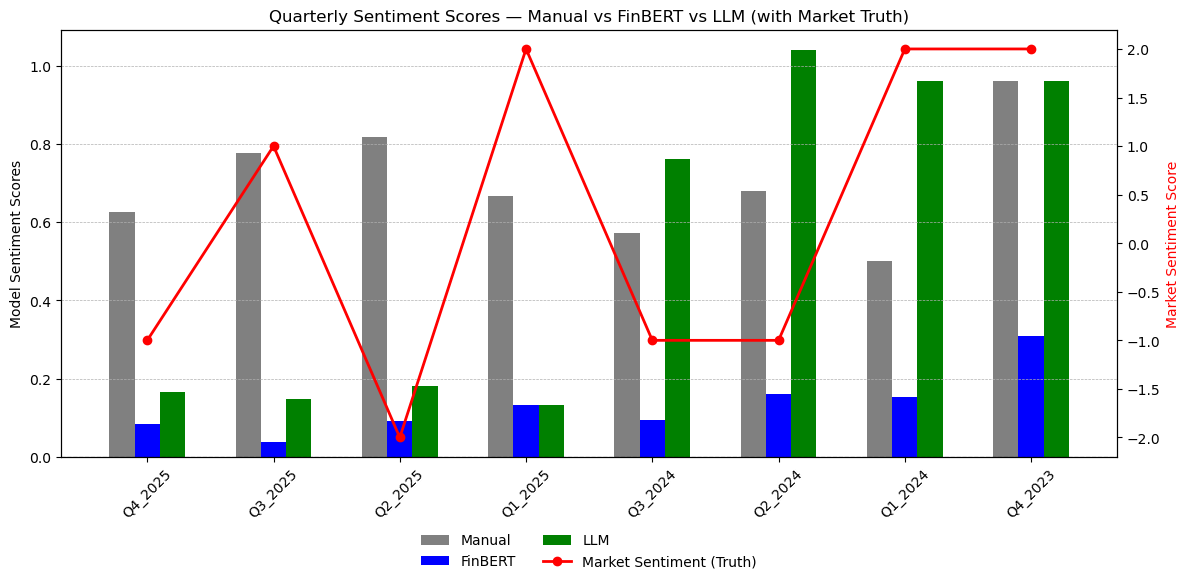

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Step 1: Convert sentiment labels to numeric scores
sentiment_to_score = {
    "Strong Negative": -2,
    "Slightly Negative": -1,
    "Neutral": 0,
    "Slightly Positive": 1,
    "Strong Positive": 2
}

# Apply to your merged DataFrame
merged_df["Market Sentiment Score"] = merged_df["Sentiment"].map(sentiment_to_score)

# Filter to rows that have all sentiment scores and Surprise(%)
valid_data = merged_df.dropna(subset=[
    "Manual Sentiment Score", 
    "FinBERT Sentiment Score", 
    "LLM Sentiment Score", 
    "Market Sentiment Score", 
    "Surprise(%)"
])

# Step 2: Bar chart with secondary y-axis for market sentiment
bar_width = 0.2
quarters = valid_data["quarter"]
index = np.arange(len(quarters))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-axis: Sentiment Bars
ax1.bar(index - bar_width, valid_data["Manual Sentiment Score"], bar_width, label="Manual", color="gray")
ax1.bar(index, valid_data["FinBERT Sentiment Score"], bar_width, label="FinBERT", color="blue")
ax1.bar(index + bar_width, valid_data["LLM Sentiment Score"], bar_width, label="LLM", color="green")
ax1.set_ylabel("Model Sentiment Scores")
ax1.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax1.set_xticks(index)
ax1.set_xticklabels(quarters, rotation=45)
ax1.grid(axis="y", linestyle="--", linewidth=0.5)

# Secondary Y-axis: Market Sentiment
ax2 = ax1.twinx()
ax2.plot(index, valid_data["Market Sentiment Score"], marker='o', linestyle='-', color='red', linewidth=2, label="Market Sentiment (Truth)")
ax2.set_ylabel("Market Sentiment Score")
ax2.yaxis.label.set_color("red")  # Make the y-axis label red

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_1 + lines_2, 
    labels_1 + labels_2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # center-bottom, outside the plot
    ncol=2,                       # display items in two columns (adjust as needed)
    frameon=False
)


plt.title("Quarterly Sentiment Scores — Manual vs FinBERT vs LLM (with Market Truth)")
plt.tight_layout()
plt.show()



## 2.2 LLM vs FinBERT vs Manual Annotation Linear Regressions

### 2.2.1 Market Sentiment Score

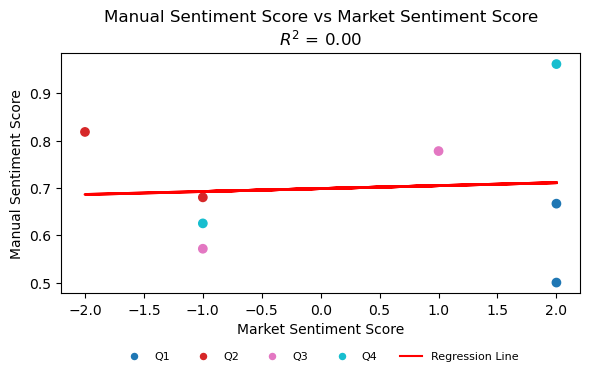

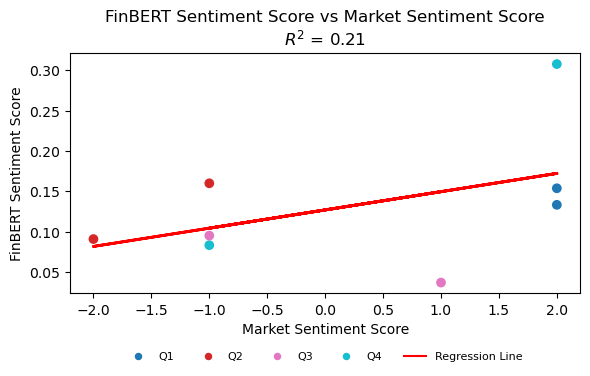

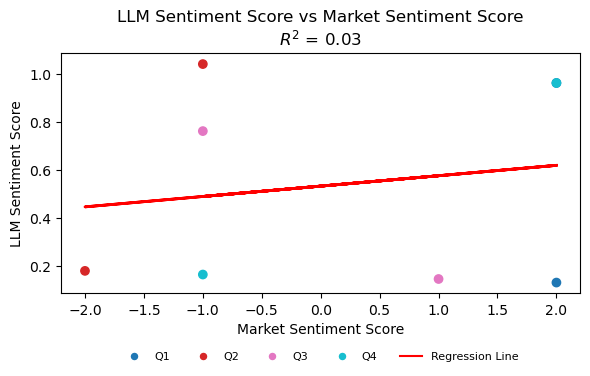

In [24]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# X-axis: Market Sentiment Score
X = valid_data[["Market Sentiment Score"]].values

# Extract just the quarter (Q1, Q2, Q3, Q4) regardless of year
quarters = valid_data["quarter"].str.split("_").str[0].astype("category")
quarter_codes = quarters.cat.codes
colors = cm.tab10(quarter_codes / quarter_codes.max())  # normalize to [0,1]

# Loop through each sentiment type
for col in ["Manual Sentiment Score", "FinBERT Sentiment Score", "LLM Sentiment Score"]:
    y = valid_data[col].values

    # Fit linear regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, c=colors, label=None)  # color by quarter only
    plt.plot(X, y_pred, color="red", linewidth=2, label="Regression Line")
    plt.xlabel("Market Sentiment Score")
    plt.ylabel(col)
    plt.title(f"{col} vs Market Sentiment Score\n$R^2$ = {r2:.2f}")

    # Add legend for quarters (Q1–Q4)
    handles = [plt.Line2D([0], [0], marker="o", color="w", label=q, 
                          markerfacecolor=cm.tab10(i / quarter_codes.max()), markersize=8)
               for i, q in enumerate(quarters.cat.categories)]
    legend = plt.legend(
    handles=handles + [plt.Line2D([], [], color="red", label="Regression Line")],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=5,                # all items in one row
    frameon=False,
    fontsize=8,            # smaller font
    title_fontsize=9,      # smaller title font
    markerscale=0.8        # shrink marker size
)


    plt.tight_layout()
    plt.show()


### 2.2.2 % Change of Stock Prices

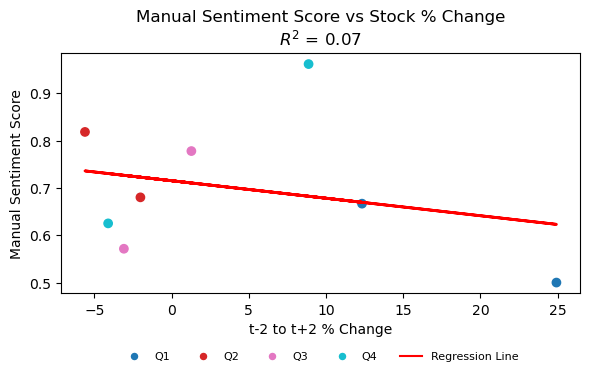

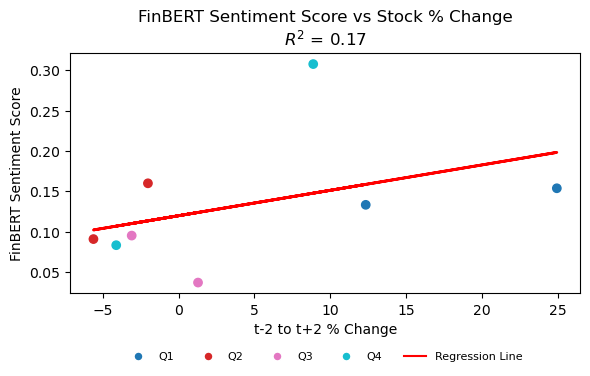

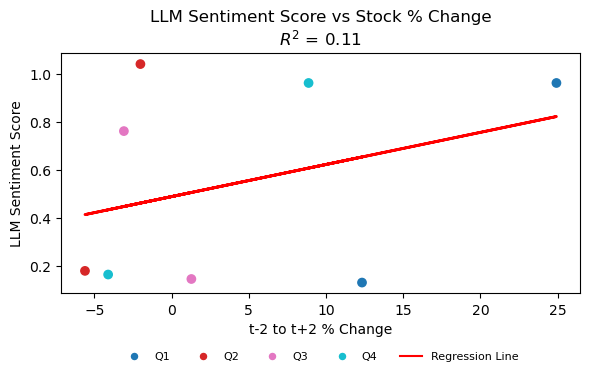

In [25]:
# X-axis: Market Sentiment Score
X = valid_data[["% Change"]].values

# Extract just the quarter (Q1, Q2, Q3, Q4) regardless of year
quarters = valid_data["quarter"].str.split("_").str[0].astype("category")
quarter_codes = quarters.cat.codes
colors = cm.tab10(quarter_codes / quarter_codes.max())  # normalize to [0,1]

# Loop through each sentiment type
for col in ["Manual Sentiment Score", "FinBERT Sentiment Score", "LLM Sentiment Score"]:
    y = valid_data[col].values

    # Fit linear regression
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, c=colors, label=None)  # color by quarter only
    plt.plot(X, y_pred, color="red", linewidth=2, label="Regression Line")
    plt.xlabel("t-2 to t+2 % Change")
    plt.ylabel(col)
    plt.title(f"{col} vs Stock % Change\n$R^2$ = {r2:.2f}")

    # Add legend for quarters (Q1–Q4)
    handles = [plt.Line2D([0], [0], marker="o", color="w", label=q, 
                          markerfacecolor=cm.tab10(i / quarter_codes.max()), markersize=8)
               for i, q in enumerate(quarters.cat.categories)]
    legend = plt.legend(
    handles=handles + [plt.Line2D([], [], color="red", label="Regression Line")],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=5,                # all items in one row
    frameon=False,
    fontsize=8,            # smaller font
    title_fontsize=9,      # smaller title font
    markerscale=0.8        # shrink marker size
)

    plt.tight_layout()
    plt.show()
